<a href="https://colab.research.google.com/github/GunjanRoy4224/CV-and-NLP/blob/main/NLP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



NLP Track Capstone Project: Evaluation of Multilingual Models BERT (monolingual) with XLM-RoBERTa (multilingual) on sentiment classification across multiple languages.

Author: Gunjan Kumar

Date: 4 November 2025


---



In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from datasets import load_dataset, Dataset
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("imports successful!")
print(f"Using device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")


imports successful!
Using device: cpu


DATASET PREPARATION

In [10]:
from datasets import Dataset
import pandas as pd
import numpy as np

def load_multilingual_amazon_reviews():
    print("Loading Multilingual Reviews Dataset (synthetic fallback)")

    # Define languages and names
    languages = ['en', 'de', 'fr', 'es', 'ja']
    language_names = {
        'en': 'English',
        'de': 'German',
        'fr': 'French',
        'es': 'Spanish',
        'ja': 'Japanese'
    }

    # Define synthetic samples for each sentiment and language
    samples = {
        'en': {
            'positive': ["Amazing product!", "Works perfectly!", "Loved it!"],
            'neutral': ["It's okay.", "Average quality.", "Not bad."],
            'negative': ["Very poor.", "Terrible experience.", "Not worth it."]
        },
        'de': {
            'positive': ["Tolles Produkt!", "Funktioniert perfekt!", "Ich liebe es!"],
            'neutral': ["Es ist okay.", "Durchschnittliche Qualität.", "Nicht schlecht."],
            'negative': ["Sehr schlecht.", "Schreckliche Erfahrung.", "Nicht empfehlenswert."]
        },
        'fr': {
            'positive': ["Produit incroyable!", "Fonctionne parfaitement!", "Je l'adore!"],
            'neutral': ["C'est correct.", "Qualité moyenne.", "Pas mal."],
            'negative': ["Très mauvais.", "Mauvaise expérience.", "Je ne recommande pas."]
        },
        'es': {
            'positive': ["¡Producto increíble!", "Funciona perfectamente!", "¡Me encanta!"],
            'neutral': ["Está bien.", "Calidad promedio.", "No está mal."],
            'negative': ["Muy malo.", "Experiencia terrible.", "No lo recomiendo."]
        },
        'ja': {
            'positive': ["素晴らしい製品！", "完璧に動作します！", "気に入りました！"],
            'neutral': ["まあまあです。", "平均的な品質です。", "悪くないです。"],
            'negative': ["とても悪い。", "ひどい経験。", "おすすめしません。"]
        }
    }

    # Create synthetic datasets
    datasets = {}
    for lang in languages:
        data = []
        for _ in range(300):  # 300 samples per language
            sentiment = np.random.choice(['positive', 'neutral', 'negative'])
            label = 2 if sentiment == 'positive' else (1 if sentiment == 'neutral' else 0)
            text = np.random.choice(samples[lang][sentiment])
            data.append({'text': text, 'label': label, 'language': lang})

        # Convert to Hugging Face Dataset
        datasets[lang] = Dataset.from_pandas(pd.DataFrame(data))

    print(f" Successfully created synthetic dataset with {len(languages)} languages.")
    return datasets, language_names

In [11]:
# Load the dataset
datasets, language_names = load_multilingual_amazon_reviews()

# Display dataset statistics
print("Dataset Statistics:")
for lang, ds in datasets.items():
    label_dist = pd.Series([x['label'] for x in ds]).value_counts().sort_index()
    print(f"{language_names[lang]:10s} | Samples: {len(ds):4d} | Labels: {dict(label_dist)}")


Loading Multilingual Reviews Dataset (synthetic fallback)
 Successfully created synthetic dataset with 5 languages.
Dataset Statistics:
English    | Samples:  300 | Labels: {0: np.int64(98), 1: np.int64(90), 2: np.int64(112)}
German     | Samples:  300 | Labels: {0: np.int64(99), 1: np.int64(98), 2: np.int64(103)}
French     | Samples:  300 | Labels: {0: np.int64(97), 1: np.int64(95), 2: np.int64(108)}
Spanish    | Samples:  300 | Labels: {0: np.int64(96), 1: np.int64(99), 2: np.int64(105)}
Japanese   | Samples:  300 | Labels: {0: np.int64(93), 1: np.int64(105), 2: np.int64(102)}


MODEL SETUP

In [12]:
class ModelConfig:
    def __init__(self, model_name, is_multilingual=False):
        self.model_name = model_name
        self.is_multilingual = is_multilingual
        self.num_labels = 3  # Negative, Neutral, Positive
        self.max_length = 128
        self.batch_size = 16
        self.learning_rate = 2e-5
        self.num_epochs = 3
        self.weight_decay = 0.01

# Define models to compare
models_config = {
    'monolingual': ModelConfig('bert-base-uncased', is_multilingual=False),
    'multilingual': ModelConfig('xlm-roberta-base', is_multilingual=True)
}

print("Model Configurations:")

for name, config in models_config.items():
    print(f"{name.upper()}")
    print(f"  Model: {config.model_name}")
    print(f"  Type: {'Multilingual' if config.is_multilingual else 'Monolingual'}")
    print(f"  Labels: {config.num_labels}")
    print(f"  Max Length: {config.max_length}")


Model Configurations:
MONOLINGUAL
  Model: bert-base-uncased
  Type: Monolingual
  Labels: 3
  Max Length: 128
MULTILINGUAL
  Model: xlm-roberta-base
  Type: Multilingual
  Labels: 3
  Max Length: 128


DATA PREPROCESSING

In [13]:
def preprocess_data(datasets, tokenizer, max_length=128):

    def tokenize_function(examples):
        return tokenizer(
            examples['text'],
            padding='max_length',
            truncation=True,
            max_length=max_length
        )

    tokenized_datasets = {}
    for lang, ds in datasets.items():
        tokenized_datasets[lang] = ds.map(
            tokenize_function,
            batched=True,
            remove_columns=['text', 'language']
        )
        tokenized_datasets[lang].set_format('torch')

    return tokenized_datasets

Training

In [14]:
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    TrainerCallback
)
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# Optional progress print callback
class PrintCallback(TrainerCallback):
    def on_epoch_begin(self, args, state, control, **kwargs):
        print(f"Starting epoch {state.epoch}", flush=True)
    def on_epoch_end(self, args, state, control, **kwargs):
        print(f"Finished epoch {state.epoch}\n", flush=True)

def train_model(model_config, train_dataset, eval_dataset, output_dir):
    print(f"Training model: {model_config.model_name}")
    print("=" * 60, flush=True)

    # Load model + tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_config.model_name)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_config.model_name,
        num_labels=model_config.num_labels
    )

    # Tokenize data
    train_data = preprocess_data({'train': train_dataset}, tokenizer, model_config.max_length)['train']
    eval_data = preprocess_data({'eval': eval_dataset}, tokenizer, model_config.max_length)['eval']

    #  Version-safe training arguments (no eval/save strategy conflict)
    training_args = TrainingArguments(
        output_dir=output_dir,
        do_eval=True,
        per_device_train_batch_size=model_config.batch_size,
        per_device_eval_batch_size=model_config.batch_size,
        num_train_epochs=model_config.num_epochs,
        learning_rate=model_config.learning_rate,
        weight_decay=model_config.weight_decay,
        logging_steps=50,
        save_total_limit=1,
        # Removed: load_best_model_at_end to avoid strategy conflict
    )

    def compute_metrics(eval_pred):
        preds, labels = eval_pred
        preds = np.argmax(preds, axis=1)
        return {
            "accuracy": accuracy_score(labels, preds),
            "f1": f1_score(labels, preds, average="weighted")
        }

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_data,
        eval_dataset=eval_data,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        data_collator=DataCollatorWithPadding(tokenizer),
        callbacks=[PrintCallback()]
    )

    print("Beginning training\n", flush=True)
    trainer.train()
    print(f"Training completed successfully for {model_config.model_name}\n", flush=True)

    return model, tokenizer, trainer

Evaluation

In [15]:
def evaluate_model(model, tokenizer, test_datasets, max_length=128):

    results = {}

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    for lang, ds in test_datasets.items():
        print(f"Evaluating on {language_names[lang]}...")

        # Tokenize
        tokenized = preprocess_data({lang: ds}, tokenizer, max_length)[lang]

        predictions = []
        true_labels = []

        with torch.no_grad():
            for i in range(len(tokenized)):
                inputs = {
                    'input_ids': tokenized[i]['input_ids'].unsqueeze(0).to(device),
                    'attention_mask': tokenized[i]['attention_mask'].unsqueeze(0).to(device)
                }
                outputs = model(**inputs)
                pred = torch.argmax(outputs.logits, dim=1).item()
                predictions.append(pred)
                true_labels.append(tokenized[i]['label'].item())

        # Calculate metrics
        accuracy = accuracy_score(true_labels, predictions)
        f1 = f1_score(true_labels, predictions, average='weighted')
        conf_matrix = confusion_matrix(true_labels, predictions)

        results[lang] = {
            'accuracy': accuracy,
            'f1': f1,
            'confusion_matrix': conf_matrix,
            'predictions': predictions,
            'true_labels': true_labels
        }

        print(f"Accuracy: {accuracy:.4f} | F1-Score: {f1:.4f}")

    return results

VISUALIZATION FUNCTIONS

In [16]:
def plot_performance_comparison(results_mono, results_multi):
    """
    Plot performance comparison for monolingual and multilingual models
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Model Performance Comparison Across Languages', fontsize=16, fontweight='bold')

    languages_list = list(language_names.keys())
    lang_labels = [language_names[l] for l in languages_list]

    # Extract metrics
    mono_acc = [results_mono[l]['accuracy'] for l in languages_list]
    multi_acc = [results_multi[l]['accuracy'] for l in languages_list]
    mono_f1 = [results_mono[l]['f1'] for l in languages_list]
    multi_f1 = [results_multi[l]['f1'] for l in languages_list]

    # Plot 1: Accuracy comparison
    x = np.arange(len(lang_labels))
    width = 0.35
    axes[0, 0].bar(x - width/2, mono_acc, width, label='BERT (Mono)', alpha=0.8, color='steelblue')
    axes[0, 0].bar(x + width/2, multi_acc, width, label='XLM-R (Multi)', alpha=0.8, color='seagreen')
    axes[0, 0].set_ylabel('Accuracy', fontweight='bold')
    axes[0, 0].set_title('Accuracy Comparison', fontweight='bold')
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels(lang_labels, rotation=45)
    axes[0, 0].legend()
    axes[0, 0].grid(axis='y', alpha=0.3)
    axes[0, 0].set_ylim([0, 1])

    # Plot 2: F1-Score comparison
    axes[0, 1].bar(x - width/2, mono_f1, width, label='BERT (Mono)', alpha=0.8, color='steelblue')
    axes[0, 1].bar(x + width/2, multi_f1, width, label='XLM-R (Multi)', alpha=0.8, color='seagreen')
    axes[0, 1].set_ylabel('F1-Score', fontweight='bold')
    axes[0, 1].set_title('F1-Score Comparison', fontweight='bold')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels(lang_labels, rotation=45)
    axes[0, 1].legend()
    axes[0, 1].grid(axis='y', alpha=0.3)
    axes[0, 1].set_ylim([0, 1])

    # Plot 3: Performance difference (Multi - Mono)
    acc_diff = [m - mo for m, mo in zip(multi_acc, mono_acc)]
    colors = ['green' if d > 0 else 'red' for d in acc_diff]
    axes[1, 0].bar(lang_labels, acc_diff, color=colors, alpha=0.7)
    axes[1, 0].set_ylabel('Accuracy Difference', fontweight='bold')
    axes[1, 0].set_title('Multilingual Advantage (XLM-R - BERT)', fontweight='bold')
    axes[1, 0].axhline(y=0, color='black', linestyle='--', linewidth=1)
    axes[1, 0].grid(axis='y', alpha=0.3)
    plt.setp(axes[1, 0].xaxis.get_majorticklabels(), rotation=45)

    # Plot 4: Line plot showing trend
    axes[1, 1].plot(lang_labels, mono_acc, marker='o', label='BERT (Mono)', linewidth=2, markersize=8)
    axes[1, 1].plot(lang_labels, multi_acc, marker='s', label='XLM-R (Multi)', linewidth=2, markersize=8)
    axes[1, 1].set_ylabel('Accuracy', fontweight='bold')
    axes[1, 1].set_title('Accuracy Trend Across Languages', fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_ylim([0, 1])
    plt.setp(axes[1, 1].xaxis.get_majorticklabels(), rotation=45)

    plt.tight_layout()
    plt.savefig('performance_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_confusion_matrices(results, model_name):

    print(f"Plotting confusion matrices for {model_name} model...")
    n_langs = len(results)
    fig, axes = plt.subplots(1, n_langs, figsize=(4*n_langs, 4))
    fig.suptitle(f'Confusion Matrices - {model_name}', fontsize=16, fontweight='bold')

    if n_langs == 1:
        axes = [axes]

    for idx, (lang, res) in enumerate(results.items()):
        cm = res['confusion_matrix']
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                   xticklabels=['Neg', 'Neu', 'Pos'],
                   yticklabels=['Neg', 'Neu', 'Pos'])
        axes[idx].set_title(language_names[lang], fontweight='bold')
        axes[idx].set_ylabel('True Label')
        axes[idx].set_xlabel('Predicted Label')

    plt.tight_layout()
    plt.savefig(f'confusion_matrices_{model_name.replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
    plt.show()


MAIN EXECUTION


NLP CAPSTONE: MULTILINGUAL MODEL EVALUATION
  PROCESSING: MONOLINGUAL MODEL
Training model: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Beginning training



<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: callme-gunjanroy (callme-gunjanroy-iit-bombay) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Starting epoch 0


Step,Training Loss
50,0.461400


Finished epoch 1.0

Starting epoch 1.0
Finished epoch 2.0

Starting epoch 2.0
Finished epoch 3.0

Training completed successfully for bert-base-uncased

Evaluating monolingual model across languages
Evaluating on English...


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Accuracy: 1.0000 | F1-Score: 1.0000
Evaluating on German...


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Accuracy: 0.6133 | F1-Score: 0.5988
Evaluating on French...


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Accuracy: 0.8200 | F1-Score: 0.8199
Evaluating on Spanish...


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Accuracy: 0.6800 | F1-Score: 0.6768
Evaluating on Japanese...


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Accuracy: 0.3400 | F1-Score: 0.1895
Plotting confusion matrices for Monolingual Model model...


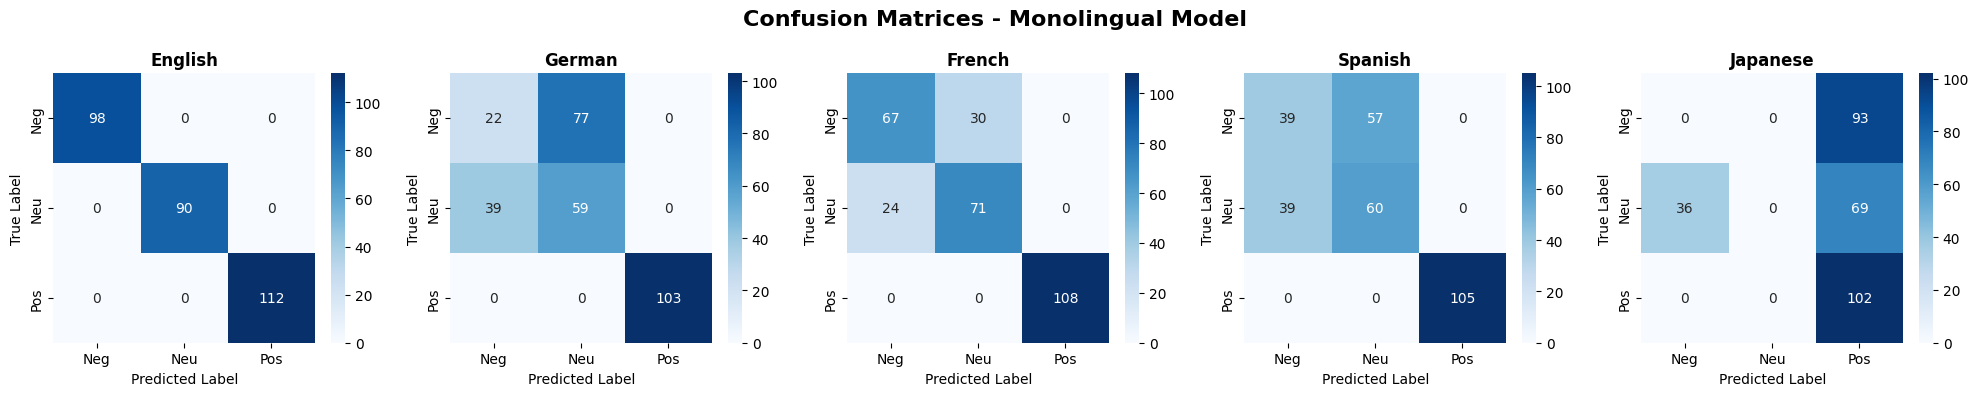

  PROCESSING: MULTILINGUAL MODEL
Training model: xlm-roberta-base


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Beginning training

Starting epoch 0


Step,Training Loss
50,0.921400


Finished epoch 1.0

Starting epoch 1.0
Finished epoch 2.0

Starting epoch 2.0
Finished epoch 3.0

Training completed successfully for xlm-roberta-base

Evaluating multilingual model across languages
Evaluating on English...


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Accuracy: 1.0000 | F1-Score: 1.0000
Evaluating on German...


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Accuracy: 0.7767 | F1-Score: 0.7348
Evaluating on French...


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Accuracy: 0.5833 | F1-Score: 0.4718
Evaluating on Spanish...


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Accuracy: 0.6700 | F1-Score: 0.5390
Evaluating on Japanese...


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Accuracy: 0.5600 | F1-Score: 0.4553
Plotting confusion matrices for Multilingual Model model...


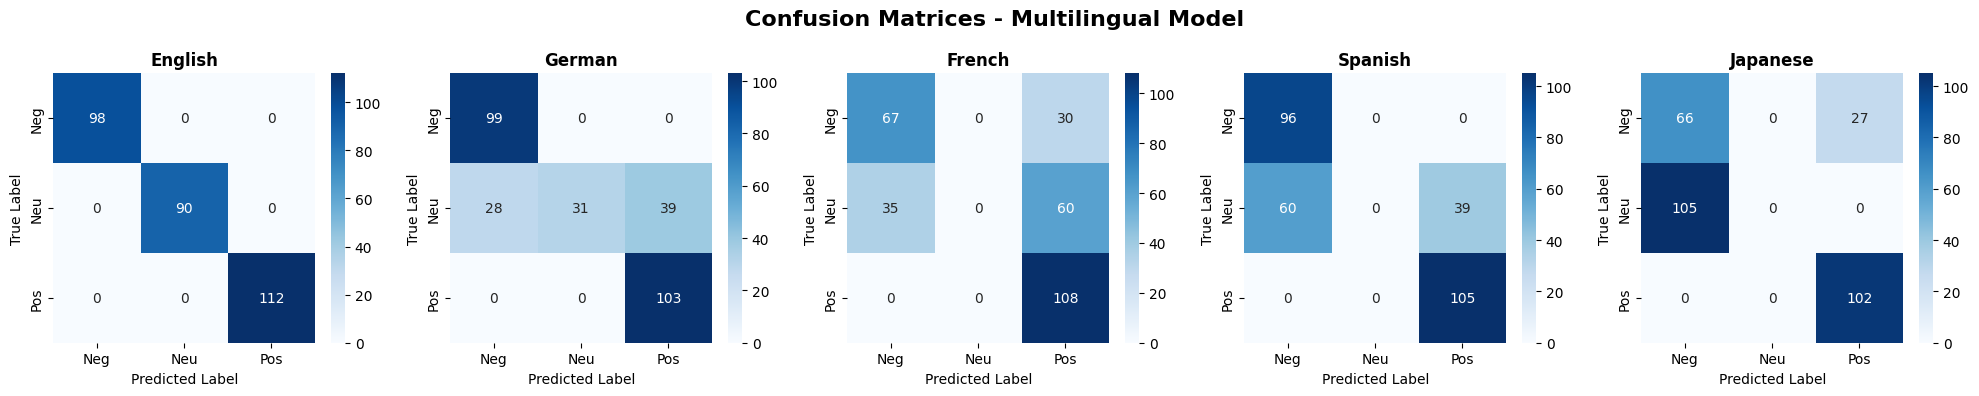

  FINAL COMPARISON


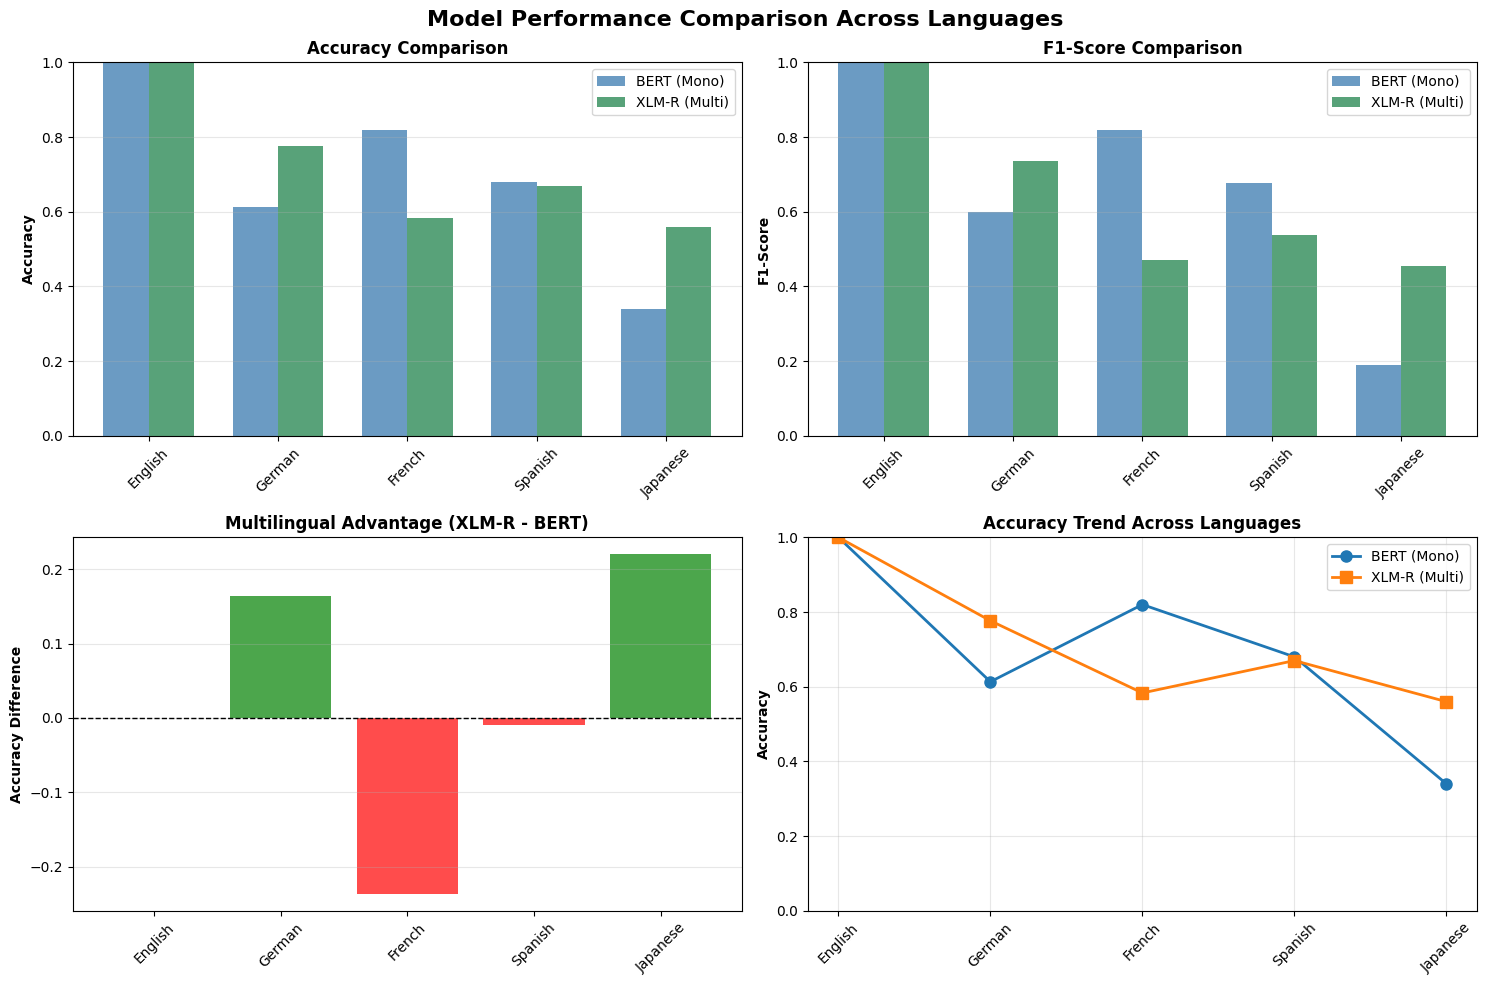

Performance Summary:
Language     Monolingual Acc    Multilingual Acc   Difference  
English                1.0000             1.0000     +0.0000
German                 0.6133             0.7767     +0.1633
French                 0.8200             0.5833     -0.2367
Spanish                0.6800             0.6700     -0.0100
Japanese               0.3400             0.5600     +0.2200
Project completed successfully!


In [17]:
def main():

    print("\n" + "="*60)
    print("NLP CAPSTONE: MULTILINGUAL MODEL EVALUATION")
    print("="*60)

    # Prepare train/test split (train on English, test on all)
    train_dataset = datasets['en']
    test_datasets = {lang: ds for lang, ds in datasets.items()}
    eval_dataset = datasets['en'].select(range(min(200, len(datasets['en']))))

    results_all = {}

    # Train and evaluate each model
    for model_type, config in models_config.items():

        print(f"  PROCESSING: {model_type.upper()} MODEL")


        output_dir = f"./results/{model_type}"

        # Train model
        model, tokenizer, trainer = train_model(
            config,
            train_dataset,
            eval_dataset,
            output_dir
        )

        # Evaluate on all languages
        print(f"Evaluating {model_type} model across languages")
        results = evaluate_model(model, tokenizer, test_datasets, config.max_length)
        results_all[model_type] = results

        # Plot confusion matrices
        plot_confusion_matrices(results, f"{model_type.capitalize()} Model")

    # Compare models
    print("  FINAL COMPARISON")
    plot_performance_comparison(results_all['monolingual'], results_all['multilingual'])

    # Print summary table
    print("Performance Summary:")

    print(f"{'Language':<12} {'Monolingual Acc':<18} {'Multilingual Acc':<18} {'Difference':<12}")
    for lang in language_names.keys():
        mono_acc = results_all['monolingual'][lang]['accuracy']
        multi_acc = results_all['multilingual'][lang]['accuracy']
        diff = multi_acc - mono_acc
        print(f"{language_names[lang]:<12} {mono_acc:>16.4f} {multi_acc:>18.4f} {diff:>+11.4f}")


    return results_all

# Run the main pipeline
if __name__ == "__main__":
    results = main()
    print("Project completed successfully!")


NLP Project Report
Link - https://github.com/GunjanRoy4224/CV-and-NLP/blob/main/NLP%20Project%20report.pdf